# Poisson equation on an annulus

$$
\mathbb{S}=
\begin{cases}
\Omega = \{(x, y)~:~R_{\text{inner}}^2 < x^2 + y^2 < R_{\text{outer}}^2\} \\
\partial\Omega_{\text{inner}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{inner}}^2 \} \\
\partial\Omega_{\text{outer}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{outer}}^2 \} \\
u_{\text{D}}\vert_{\partial\Omega_{\text{inner}}}=0 \\
u_{\text{D}}\vert_{\partial\Omega_{\text{outer}}}=1 \\
f=0 \\
u_{\text{e}}(r)=\frac{\ln(r/R_{\text{inner}})}{\ln(R_{\text{outer}}/R_{\text{inner}})}~~,~~r=\sqrt{x^2+y^2}
\end{cases}$$

In [ ]:
import numpy as np
from dolfinx.fem import FunctionSpace
from lucifex.mesh import annulus_mesh, mesh_boundary
from lucifex.fem import Function, Constant
from lucifex.solver import bvp, BoundaryConditions
from lucifex.viz import plot_colormap, plot_mesh
from lucifex.utils import triangulation
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.poisson import poisson

Rinner = 1.0
Router = 2.0
Nradial = 10
dr = (Router - Rinner) / Nradial
mesh = annulus_mesh(dr, 'triangle')(Rinner, Router)
boundary = mesh_boundary(
    mesh, 
    {
        "inner": lambda x: x[0]**2 + x[1]**2 - Rinner**2,
        "outer": lambda x: x[0]**2 + x[1]**2 - Router**2,
    },
)

fs = FunctionSpace(mesh, ('P', 1))
f = Constant(mesh, 0.0)

bcs = BoundaryConditions(
    ("dirichlet", boundary['inner'], 0.0),
    ("dirichlet", boundary['outer'], 1.0),  
)
u = Function(fs, name='u')
u_solver = bvp(poisson, bcs)(u, f)
u_solver.solve()

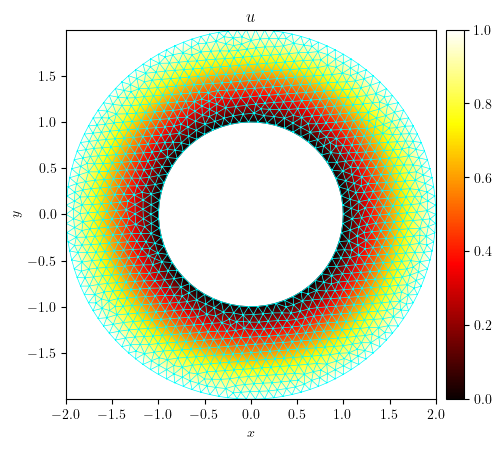

In [2]:
mesh_tri = triangulation(mesh)
u_tri = triangulation(u)
x, y = mesh_tri.x, mesh_tri.y

fig, ax = plot_colormap((mesh_tri, u_tri), cartesian=False, triangles=mesh_tri.triangles)
plot_mesh(fig, ax, mesh, title='$u$', color='cyan', linewidth=0.5)
write(fig, get_ipynb_file_name(), './figures', close=False, pickle=False)

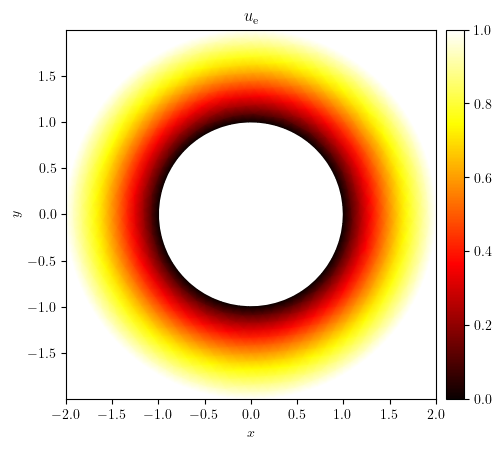

In [4]:
def exact_solution(x, y, Rinner, Router):
    r = np.sqrt(x**2 + y**2)
    return np.log(r / Rinner) / np.log(Router / Rinner)

ue = [exact_solution(xi, yi, Rinner, Router) for xi, yi in zip(x, y)]

fig, ax = plot_colormap(
    (x, y, ue), 
    title='$u_{\mathrm{e}}$', 
    cartesian=False, 
    triangles=mesh_tri.triangles,
)

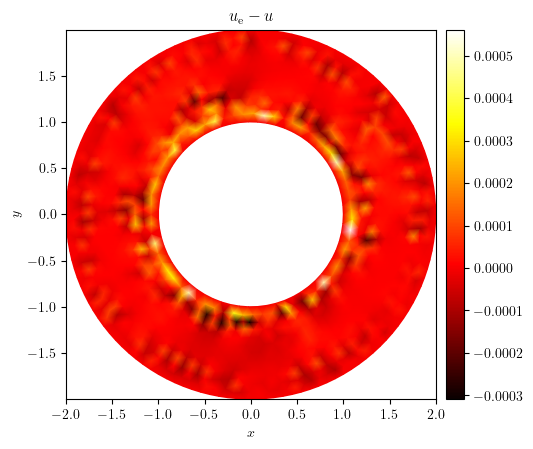

: 

In [ ]:
error = np.subtract(ue, u_tri)
fig, ax = plot_colormap(
    (x, y, error), 
    title='$u_{\mathrm{e}} - u$', 
    cartesian=False, 
    triangles=mesh_tri.triangles,
)